#### Introduction

From [https://archive.ics.uci.edu/ml/datasets/wine+quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link](https://www.vinhoverde.pt/en/) or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Let's combine these datasets and add a new feature - the type of wine.


That is, the list of all features will look like this:

* 0 - wine type
* 1 - fixed acidity 
* 2 - volatile acidity 
* 3 - citric acid 
* 4 - residual sugar 
* 5 - chlorides 
* 6 - free sulfur dioxide 
* 7 - total sulfur dioxide 
* 8 - density 
* 9 - pH 
* 10 - sulphates 
* 11 - alcohol

Output variable (based on sensory data): 
* 12 - quality (score between 0 and 10)

#### Part 1: Import library and set constants

In [19]:
import csv

import catboost
import numpy as np
import numpy.typing as npt
from sklearn import metrics
from typing import Any
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

TRAIN_DATA = "../data/train.csv"
VAL_DATA = "../data/val.csv"
TEST_DATA = "../data/test.csv"
SEED = 21
CAT_FEATURES_INDICES = [0] # wine type

#### Part 2: Load data

In [2]:
train = pd.read_csv(TRAIN_DATA, sep=";")
val = pd.read_csv(VAL_DATA, sep=";")
test = pd.read_csv(TEST_DATA, sep=";")

In [3]:
train.head()

,wine type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.1,0.20,0.31,6.85,0.053,32.0,211.0,0.99587,3.31,0.59,10.4,6
1,0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.99710,3.24,0.66,9.6,6
2,1,7.8,0.18,0.31,12.20,0.053,46.0,140.0,0.99800,3.06,0.53,8.9,6
3,1,6.0,0.25,0.28,7.70,0.053,37.0,132.0,0.99489,3.06,0.50,9.4,6
4,0,7.8,0.59,0.33,2.00,0.074,24.0,120.0,0.99680,3.25,0.54,9.4,5


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5199 entries, 0 to 5198
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wine type             5199 non-null   int64  
 1   fixed acidity         5199 non-null   float64
 2   volatile acidity      5199 non-null   float64
 3   citric acid           5199 non-null   float64
 4   residual sugar        5199 non-null   float64
 5   chlorides             5199 non-null   float64
 6   free sulfur dioxide   5199 non-null   float64
 7   total sulfur dioxide  5199 non-null   float64
 8   density               5199 non-null   float64
 9   pH                    5199 non-null   float64
 10  sulphates             5199 non-null   float64
 11  alcohol               5199 non-null   float64
 12  quality               5199 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 528.1 KB


In [5]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wine type             649 non-null    int64  
 1   fixed acidity         649 non-null    float64
 2   volatile acidity      649 non-null    float64
 3   citric acid           649 non-null    float64
 4   residual sugar        649 non-null    float64
 5   chlorides             649 non-null    float64
 6   free sulfur dioxide   649 non-null    float64
 7   total sulfur dioxide  649 non-null    float64
 8   density               649 non-null    float64
 9   pH                    649 non-null    float64
 10  sulphates             649 non-null    float64
 11  alcohol               649 non-null    float64
 12  quality               649 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 66.0 KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wine type             649 non-null    int64  
 1   fixed acidity         649 non-null    float64
 2   volatile acidity      649 non-null    float64
 3   citric acid           649 non-null    float64
 4   residual sugar        649 non-null    float64
 5   chlorides             649 non-null    float64
 6   free sulfur dioxide   649 non-null    float64
 7   total sulfur dioxide  649 non-null    float64
 8   density               649 non-null    float64
 9   pH                    649 non-null    float64
 10  sulphates             649 non-null    float64
 11  alcohol               649 non-null    float64
 12  quality               649 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 66.0 KB


In [7]:
def split_into_x_y(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    x = data.iloc[:, 0:-1]
    y = data.iloc[:, -1]
    return x, y

x_train, y_train = split_into_x_y(train)
x_val, y_val = split_into_x_y(val)
x_test, y_test = split_into_x_y(test)

#### Part 3: Explorary data analysis

(array([  5.,   0.,  17.,   0., 231.,   0., 273.,   0., 112.,  11.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

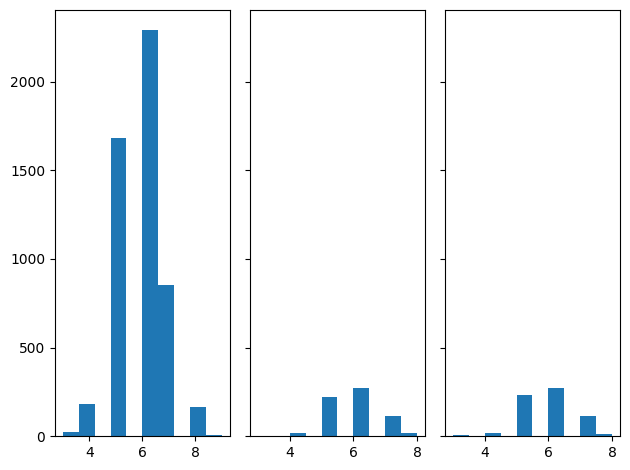

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(y_train)
axs[1].hist(y_val)
axs[2].hist(y_test)

<Axes: >

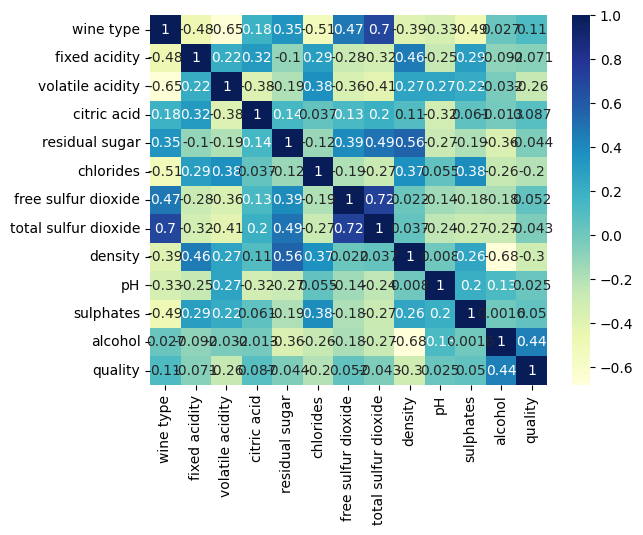

In [9]:
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)

#### Part 4: Train the model

In [10]:
model = catboost.CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    loss_function="MultiClass",
    task_type="GPU",
    eval_metric="TotalF1:average=Micro",
    random_seed=SEED
)

model.fit(
    x_train,
    y_train,
    eval_set=(x_val, y_val),
    cat_features=CAT_FEATURES_INDICES,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Part 5: Model evaluation

In [11]:
prediction = model.predict(x_test)

f1 = metrics.f1_score(y_test, prediction, average="micro")
precision = metrics.precision_score(y_test, prediction, average="micro")
recall = metrics.recall_score(y_test, prediction, average="micro")
accuracy = metrics.accuracy_score(y_test, prediction)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}")

Accuracy: 0.6640986132511556
Precision: 0.6640986132511556
Recall: 0.6640986132511556
F1: 0.6640986132511556


#### Part 6: Gridsearch to tune hyperparameters

In [14]:
model = catboost.CatBoostClassifier(
    iterations=2000,
    loss_function="MultiClass",
    task_type="GPU",
    eval_metric="TotalF1:average=Micro",
    random_seed=SEED,
    logging_level='Silent'
)

grid = {
    "learning_rate": [5e-5, 0.001, 0.1, 0.5, 1],
    "depth": [4, 6, 10],
    "l2_leaf_reg": [1, 3, 5, 7]
}

grid_search_result = model.grid_search(grid, X=x_train, y=y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
print(f"The best parameters: {grid_search_result['params']}")

The best parameters: {'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


#### Eval the best model on test dataset

In [23]:
model = catboost.CatBoostClassifier(
    iterations=1000,
    loss_function="MultiClass",
    task_type="GPU",
    eval_metric="TotalF1:average=Micro",
    random_seed=SEED,
    **grid_search_result["params"]
)

model.fit(
    x_train,
    y_train,
    eval_set=(x_val, y_val),
    cat_features=CAT_FEATURES_INDICES,
    verbose=False,
    plot=True
)

predictions = model.predict(x_test)

f1 = metrics.f1_score(y_test, predictions, average="micro")
accuracy = metrics.accuracy_score(y_test, prediction)
print(f"F1: {f1}\n Accuracy: {accuracy}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

F1: 0.6856702619414484
 Accuracy: 0.6640986132511556
